In [1]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift
import scipy.cluster.hierarchy as shc
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import tqdm
import boto3
import s3fs

In [2]:
client=boto3.client('s3')

# Import/Format Data

In [3]:
data=pd.read_csv('s3://ms-syntheamass-1m-mldata/syntheamassCSV/output_1/csv/patients.csv')
dataOG=pd.read_csv('s3://ms-syntheamass-1m-mldata/syntheamassCSV/output_1/csv/patients.csv')
data['BIRTHDATE']=data['BIRTHDATE'].str.replace('-', '')
data['BIRTHDATE']=data['BIRTHDATE'].astype(float)
data=data.drop(['ID','DEATHDATE','MAIDEN','SSN','DRIVERS','PASSPORT','PREFIX','FIRST','LAST','SUFFIX','BIRTHPLACE','ADDRESS'],axis=1)
data['MARITAL']=data['MARITAL'].fillna(0)
data['MARITAL']=data['MARITAL'].replace({'M':1})
data['MARITAL']=data['MARITAL'].replace({'S':0})
data['GENDER']=data['GENDER'].replace({'M':1})
data['GENDER']=data['GENDER'].replace({'F':0})
data.head()

,BIRTHDATE,MARITAL,RACE,ETHNICITY,GENDER
0,19960726.0,0,white,irish,0
1,19960924.0,0,white,french_canadian,0
2,19440901.0,1,white,irish,1
3,19640514.0,1,white,french,0
4,19460305.0,0,white,irish,0


# Set Up Observation Data Frame

In [10]:
dfm=pd.read_csv('s3://ms-syntheamass-1m-mldata/syntheamassCSV/patient_info/bigObs')

In [11]:
dfm.columns=['Patient','Body Mass','Body Height','BMI','Cholesterol']
dfm.head()

,Patient,Body Mass,Body Height,BMI,Cholesterol
0,0042d5b6-f461-45d3-8f2a-4b152a719ab8,156.51,71.62,29.24,189.0
1,0057dc7b-879d-4ef0-813f-a01583977251,151.11,103.05,45.13,182.0
2,00c343e4-e4eb-4c60-8707-65b98c25887e,176.61,116.12,37.23,163.0
3,00ceb21f-3c0e-4c16-b497-1af82d621867,166.28,118.64,42.91,172.0
4,00e7990c-e3ae-4221-95ed-d0dfb6a2d9d7,171.15,127.63,43.57,195.0


In [12]:
dfm.shape

(65174, 5)

# Merge Patient/observation Dataframe

In [13]:
data.head()

,BIRTHDATE,MARITAL,RACE,ETHNICITY,GENDER
0,19960726.0,0,white,irish,0
1,19960924.0,0,white,french_canadian,0
2,19440901.0,1,white,irish,1
3,19640514.0,1,white,french,0
4,19460305.0,0,white,irish,0


In [14]:
df=pd.concat([data,dfm],axis=1)
df=df.drop(['Patient'],axis=1)
df.head()

,BIRTHDATE,MARITAL,RACE,ETHNICITY,GENDER,Body Mass,Body Height,BMI,Cholesterol
0,19960726.0,0,white,irish,0,156.51,71.62,29.24,189.0
1,19960924.0,0,white,french_canadian,0,151.11,103.05,45.13,182.0
2,19440901.0,1,white,irish,1,176.61,116.12,37.23,163.0
3,19640514.0,1,white,french,0,166.28,118.64,42.91,172.0
4,19460305.0,0,white,irish,0,171.15,127.63,43.57,195.0


In [15]:
dfcopy=df.copy()
dfcopy=dfcopy.dropna()
dfcopy=dfcopy.sample(frac=1, random_state=7896)
dfcopy.to_csv()
dfcopy.head()

,BIRTHDATE,MARITAL,RACE,ETHNICITY,GENDER,Body Mass,Body Height,BMI,Cholesterol
24778,19851120.0,1,hispanic,puerto_rican,0,182.64,99.45,29.82,200.0
8771,19931003.0,0,white,italian,0,162.19,92.35,35.10,192.0
10891,20060901.0,0,white,irish,0,177.83,100.51,31.78,192.0
40738,19930907.0,0,hispanic,central_american,1,190.18,106.35,29.40,191.0
61513,19280501.0,0,white,irish,1,168.73,96.17,33.78,168.0


## Encode Categories

In [16]:
enc = preprocessing.OrdinalEncoder()
X=df.iloc[:,2:4].values
enc.fit(X)

OrdinalEncoder()

In [17]:
X=enc.transform(X)
cols=['RACE','ETHNICITY']
df[cols]=X

In [18]:
df=df.dropna()
df=df.sample(frac=1, random_state=7896)
df.head()

,BIRTHDATE,MARITAL,RACE,ETHNICITY,GENDER,Body Mass,Body Height,BMI,Cholesterol
24778,19851120.0,1,5.0,18.0,0,182.64,99.45,29.82,200.0
8771,19931003.0,0,7.0,14.0,0,162.19,92.35,35.10,192.0
10891,20060901.0,0,7.0,13.0,0,177.83,100.51,31.78,192.0
40738,19930907.0,0,5.0,6.0,1,190.18,106.35,29.40,191.0
61513,19280501.0,0,7.0,13.0,1,168.73,96.17,33.78,168.0


In [19]:
df=df.drop([38775])

# Hierachical Clustering

## Mean Shift

In [20]:
clf=MeanShift()
clf.fit(df)
labels=clf.labels_
cluster_centers=clf.cluster_centers_
dfcopy['cluster_group']=np.nan
df['cluster_group']=np.nan

In [27]:
for i in tqdm.tqdm(range(len(df))):
    dfcopy['cluster_group'].iloc[i]=labels[i]
    df['cluster_group'].iloc[i]=labels[i]
n_clusters_ =len(np.unique(labels))
print(n_clusters_)

100%|██████████| 65173/65173 [1:54:12<00:00,  9.51it/s]  

2


In [28]:
dfcopy.head()

,BIRTHDATE,MARITAL,RACE,ETHNICITY,GENDER,Body Mass,Body Height,BMI,Cholesterol,cluster_group
24778,19851120.0,1,hispanic,puerto_rican,0,182.64,99.45,29.82,200.0,1.0
8771,19931003.0,0,white,italian,0,162.19,92.35,35.10,192.0,1.0
10891,20060901.0,0,white,irish,0,177.83,100.51,31.78,192.0,1.0
40738,19930907.0,0,hispanic,central_american,1,190.18,106.35,29.40,191.0,1.0
61513,19280501.0,0,white,irish,1,168.73,96.17,33.78,168.0,0.0


### Analyzing Groups

In [29]:
temp0=dfcopy[dfcopy['cluster_group']==0]
len(temp0)

36221

In [30]:
temp1=dfcopy[dfcopy['cluster_group']==1]
len(temp1)

28952

#### Looking at Outlier Group

In [33]:
temp1.head(20)

,BIRTHDATE,MARITAL,RACE,ETHNICITY,GENDER,Body Mass,Body Height,BMI,Cholesterol,cluster_group
24778,19851120.0,1,hispanic,puerto_rican,0,182.64,99.45,29.82,200.0,1.0
8771,19931003.0,0,white,italian,0,162.19,92.35,35.10,192.0,1.0
10891,20060901.0,0,white,irish,0,177.83,100.51,31.78,192.0,1.0
40738,19930907.0,0,hispanic,central_american,1,190.18,106.35,29.40,191.0,1.0
47646,20140428.0,0,white,english,1,161.06,105.31,40.60,188.0,1.0
53679,19820825.0,0,white,irish,0,158.51,82.13,32.69,179.0,1.0
13643,19971018.0,0,white,english,0,181.71,97.00,29.38,200.0,1.0
27583,19760807.0,1,hispanic,puerto_rican,1,184.98,107.18,31.32,190.0,1.0
39162,19870107.0,1,white,american,0,161.91,92.82,35.41,173.0,1.0
42630,20160331.0,0,hispanic,puerto_rican,0,160.22,66.00,25.71,173.0,1.0


# PCA for Data Visualization

In [34]:
pca=PCA(n_components=3)
principalComponents=pca.fit_transform(df)
principalDF = pd.DataFrame(data=principalComponents, columns =['Principal Component 1', 'Principal Component 2','Principal Component 3'])
principalDF.head()

,Principal Component 1,Principal Component 2,Principal Component 3
0,-184652.322021,14.412146,6.396685
1,-264535.322023,4.090113,10.172524
2,-394433.322021,7.879886,1.935391
3,-264439.322019,9.747272,-4.544748
4,385966.677980,-15.355093,-4.700567


In [35]:
finalDF=pd.concat([principalDF, df[['cluster_group']]],axis=1)
finalDF.head()

,Principal Component 1,Principal Component 2,Principal Component 3,cluster_group
0,-184652.322021,14.412146,6.396685,1.0
1,-264535.322023,4.090113,10.172524,1.0
2,-394433.322021,7.879886,1.935391,0.0
3,-264439.322019,9.747272,-4.544748,0.0
4,385966.677980,-15.355093,-4.700567,0.0


### 2D

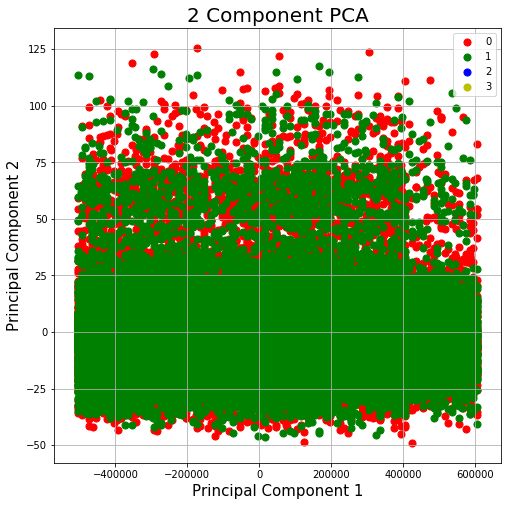

In [36]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = [0,1,2,3]
colors = ['r', 'g', 'b','y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDF['cluster_group'] == target
    ax.scatter(finalDF.loc[indicesToKeep, 'Principal Component 1']
               , finalDF.loc[indicesToKeep, 'Principal Component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### 3D

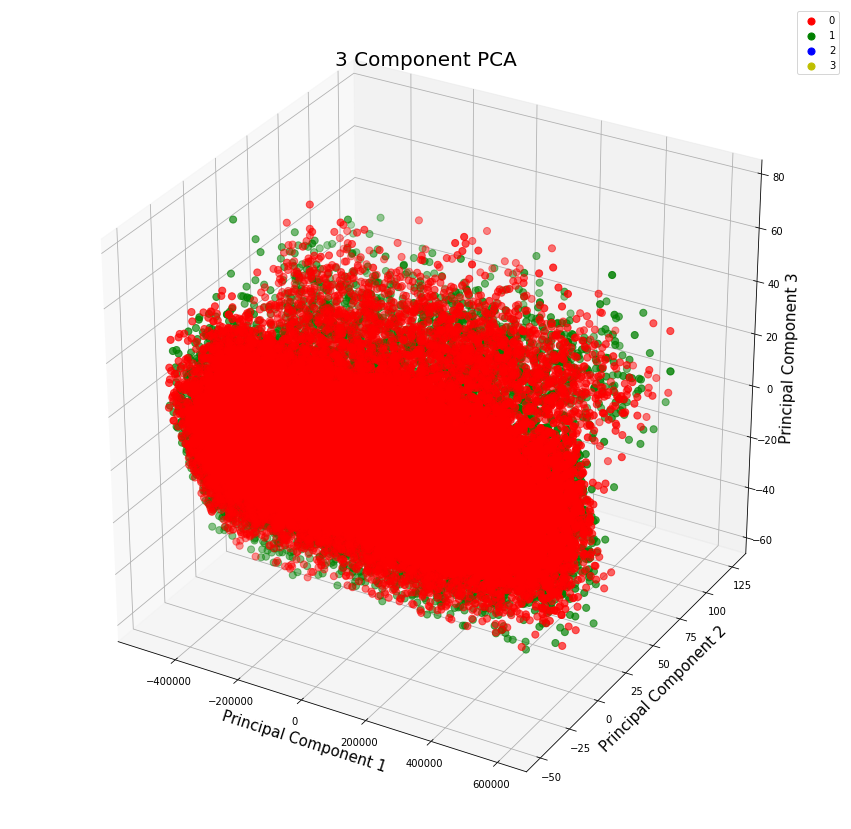

In [37]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111,projection='3d') 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 Component PCA', fontsize = 20)


targets = [0,1,2,3]
colors = ['r', 'g', 'b','y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDF['cluster_group'] == target
    ax.scatter(finalDF.loc[indicesToKeep, 'Principal Component 1']
               , finalDF.loc[indicesToKeep, 'Principal Component 2']
               , finalDF.loc[indicesToKeep, 'Principal Component 3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()